In [65]:
# ============================================
# 📊 Predicting Page Duration (durationMs_log)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [66]:
# ============================================
# 🧩 Load and prepare dataset
# ============================================
input_path = "cleaned_advanced_events.csv"  # update if needed
df = pd.read_csv(input_path, low_memory=False)

print(f"✅ Loaded: {df.shape}")

✅ Loaded: (134911, 27)


In [67]:
print(df.isnull().sum())

eventType                    0
url                          0
browser                      0
language                     0
country                      0
region                       0
city                         0
timezone                     0
clickX                       0
clickY                       0
scrollPercent                0
durationMs                   0
domLoadTime                  0
fullLoadTime                 0
ttfb                         0
downlink                     0
effectiveType                0
rtt                          0
errorMessage                 0
errorSource                  0
errorLine                    0
errorColumn                  0
screenWidth                  0
screenHeight                 0
aspectRatio                  0
screenResolution_bin    134911
durationMs_log               0
dtype: int64


In [68]:
df.drop(columns=["screenResolution_bin"], inplace=True, errors="ignore")

In [69]:
# === Features & Target ===
target_col = "durationMs_log"
X = df.drop(columns=[target_col, "durationMs"], errors="ignore")
y = df[target_col]

# === Split train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [70]:
# ============================================
# ⚡ Utility — Evaluation Function
# ============================================
def evaluate_model(name, model, X_test, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name:20} | MAE: {mae:10.4f} | RMSE: {rmse:10.4f} | R²: {r2:6.3f}")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

results = []

In [71]:
# ============================================
# 🌳 Random Forest
# ============================================
print("\nTraining RandomForest...")
rf = RandomForestRegressor(
    n_estimators=150, max_depth=20, n_jobs=-1, random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results.append(evaluate_model("RandomForest", rf, X_test, y_test, y_pred_rf))


Training RandomForest...
RandomForest         | MAE:     0.2742 | RMSE:     0.7841 | R²:  0.576


In [72]:
# ============================================
# 🌄 Gradient Boosting
# ============================================
print("\nTraining GradientBoosting...")
gb = GradientBoostingRegressor(
    n_estimators=250, learning_rate=0.05, max_depth=5, random_state=42
)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
results.append(evaluate_model("GradientBoosting", gb, X_test, y_test, y_pred_gb))


Training GradientBoosting...
GradientBoosting     | MAE:     0.3550 | RMSE:     0.8620 | R²:  0.488


In [73]:
# ============================================
# ⚡ XGBoost
# ============================================
print("\nTraining XGBoost...")
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42,
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results.append(evaluate_model("XGBoost", xgb, X_test, y_test, y_pred_xgb))


Training XGBoost...
XGBoost              | MAE:     0.3169 | RMSE:     0.8107 | R²:  0.547


In [74]:
# ============================================
# 💡 LightGBM
# ============================================
print("\nTraining LightGBM...")
lgbm = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=40,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
results.append(evaluate_model("LightGBM", lgbm, X_test, y_test, y_pred_lgbm))


Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2334
[LightGBM] [Info] Number of data points in the train set: 107928, number of used features: 21
[LightGBM] [Info] Start training from score 11.141301
LightGBM             | MAE:     0.3156 | RMSE:     0.8070 | R²:  0.551



=== Model Comparison ===
              Model       MAE      RMSE        R2
0      RandomForest  0.274202  0.784070  0.576084
1  GradientBoosting  0.354994  0.861988  0.487644
2           XGBoost  0.316950  0.810740  0.546756
3          LightGBM  0.315572  0.807048  0.550875


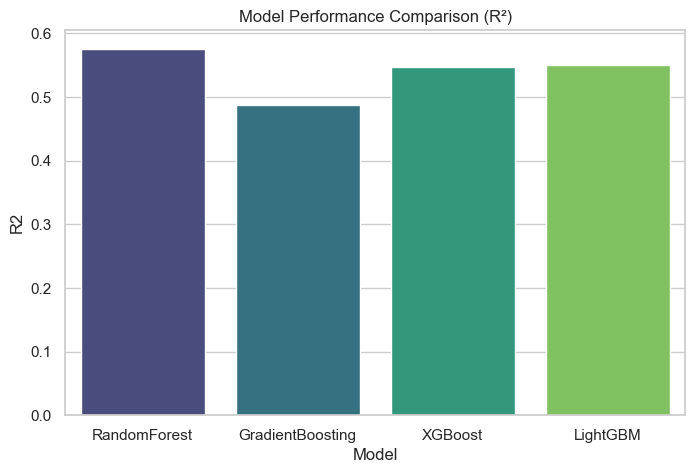

In [75]:
# ============================================
# 📊 Compare Models
# ============================================
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Model", y="R2", palette="viridis")
plt.title("Model Performance Comparison (R²)")
plt.show()

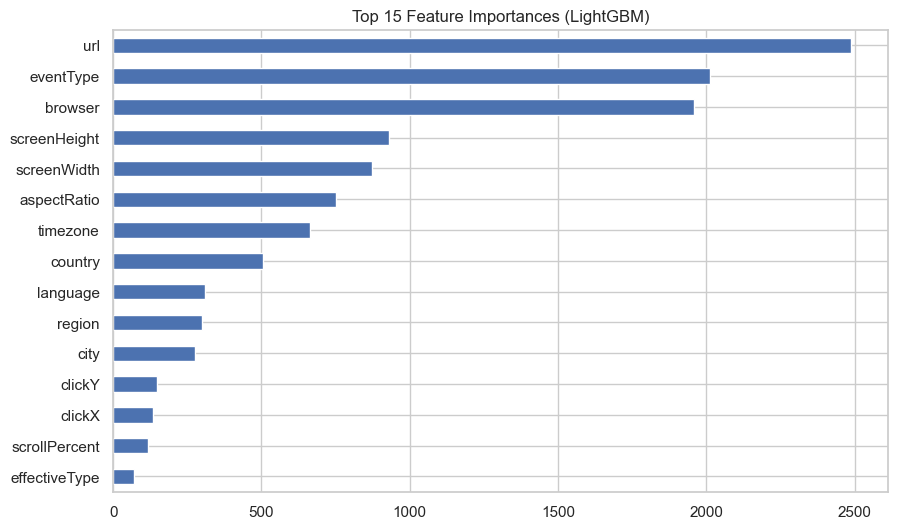

In [76]:
# ============================================
# 🌟 Feature Importance Visualization
# ============================================
best_model = lgbm  # change if another performs better
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (LightGBM)")
plt.show()

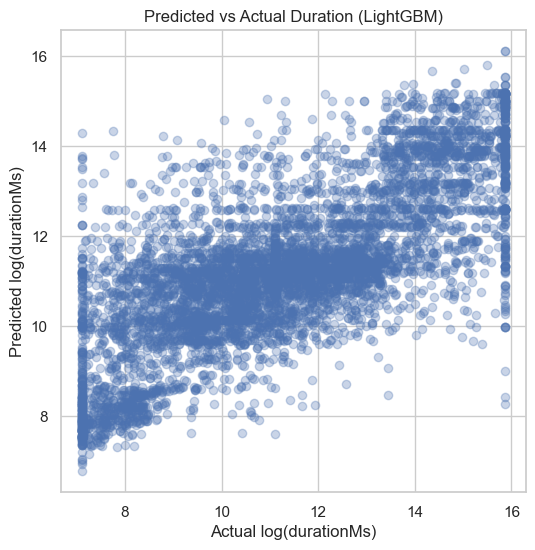

In [77]:
# ============================================
# 🔍 Scatter Plot: Predictions vs Actual
# ============================================
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lgbm, alpha=0.3)
plt.xlabel("Actual log(durationMs)")
plt.ylabel("Predicted log(durationMs)")
plt.title("Predicted vs Actual Duration (LightGBM)")
plt.grid(True)
plt.show()